# Tensorflow Probability & Treeflow Demo

In [100]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

## Tensorflow Probability distributions
Represents distributions on `tf.Tensor` (or nested structures of tensors)

### Properties
* `dtype`
* `reparameterization_type`

### Core methods
* `log_prob`
* `sample`

### Shape

* **Event shape** - shape of a single draw (may or may not be dependent across dimensions)
* **Batch shape** - independent samples from a collection of distributions (may or may not be i.i.d.)
* **Sample shape** - i.i.d draws - specific to `log_prob` / `sample` call

In [22]:
mus = np.random.normal(size=(3, 2))
norm = tfd.Normal(mus, 1.0)
dirichlet = tfd.Dirichlet(np.exp(mus))
dists = norm, tfd.Sample(norm, sample_shape=4), tfd.Independent(norm, reinterpreted_batch_ndims=1), dirichlet
dists

(<tfp.distributions.Normal 'Normal' batch_shape=[3, 2] event_shape=[] dtype=float64>,
 <tfp.distributions.Sample 'SampleNormal' batch_shape=[3, 2] event_shape=[4] dtype=float64>,
 <tfp.distributions.Independent 'IndependentNormal' batch_shape=[3] event_shape=[2] dtype=float64>,
 <tfp.distributions.Dirichlet 'Dirichlet' batch_shape=[3] event_shape=[2] dtype=float64>)

In [21]:
[dist.sample().shape for dist in dists]

[TensorShape([3, 2]), TensorShape([3, 2, 4]), TensorShape([3, 2])]

## Automatic differentiation

In [81]:
mu = tf.convert_to_tensor(2.0)

with tf.GradientTape() as t:
    t.watch(mu)
    dist = tfd.Normal(mu, 1.0)
    logp = dist.log_prob(1.2)
    
logp, t.gradient(logp, mu)

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.2389385>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.79999995>)

### Reparameterization trick

In [79]:
with tf.GradientTape() as t:
    t.watch(mu)
    dist = tfd.Normal(mu, 1.0)
    samples = dist.sample(2)
    res = tfp.monte_carlo.expectation(lambda x: x ** 2.0, samples, log_prob=dist.log_prob)
    
res, t.gradient(res, mu)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9469414>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.7821376>)

## Distributions on trees
* Distribution on (nested) dictionary of tensors
  * Topology
  * Heights
    * Leaf heights included in "data" - not clear what the right decision is
* [`treeflow.tree`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/tree.py) - Base class `TreeDistribution`
* [`treeflow.coalescent`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/coalescent.py)
* [`treeflow.birthdeath`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/birthdeath.py)
* (sampling not yet implemented)

In [56]:
from treeflow.coalescent import ConstantCoalescent

coalescent = ConstantCoalescent(3, 10.0, np.zeros(3))
# Some problem with shape functions - using sample to show shape
coalescent.sample()

/mnt/c/chris/git/treeflow/treeflow/coalescent.py:70: UserWarning: Dummy sampling
  warnings.warn('Dummy sampling')


{'heights': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
 'topology': {'parent_indices': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 0, 0, 0], dtype=int32)>}}

In [85]:
parent_indices = [3, 3, 4, 4]

coalescent.log_prob({
    'heights': tf.convert_to_tensor([[0, 0, 0, 1.0, 2.0], [0, 0, 0, 0.8, 2.2]]),
    'topology': { 'parent_indices': tf.convert_to_tensor([parent_indices, parent_indices])  }
})

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-5.0051703, -4.9851704], dtype=float32)>

## Tensorflow Probability bijectors
Transformations of distributions
* Works with `TransformedDistribution`
* Simple transformations like `Exp`, `Sigmoid`
* Trainable transformations like `MaskedAutoregressiveFlow`
* Compositions like `Chain`, `Blockwise`
### Core methods
* `forward`
* `inverse`
* `log_det_jacobian` (of inverse)

In [65]:
log_normal = tfd.TransformedDistribution(norm, tfp.bijectors.Exp())
log_normal.sample()

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[12.53768388,  0.41236635],
       [ 0.09048332,  4.60196322],
       [ 0.21713642,  0.87283682]])>

## Bijectors for trees
* [`treeflow.tree_transform`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/tree_transform.py)
  * Note: indexing conventions are not very standardised
* Distributions on node heights constructed in  [`treeflow.model`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/model.py)

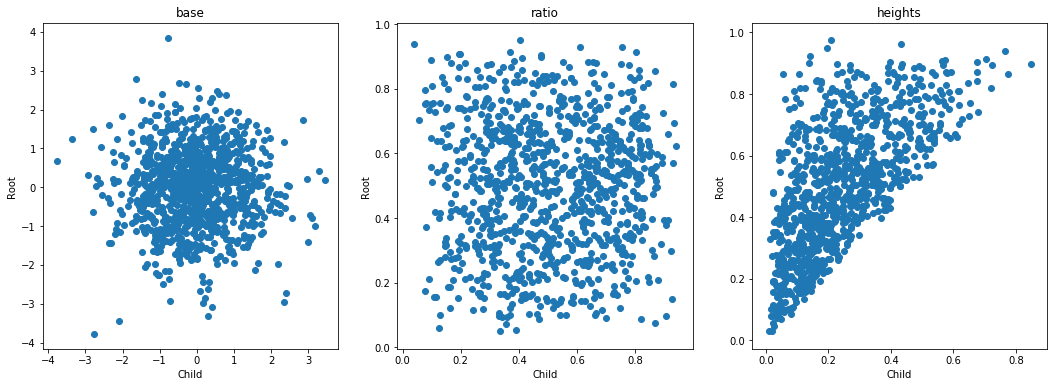

In [120]:
from treeflow.tree_transform import BranchBreaking

base_dist = tfd.Independent(tfd.Normal(tf.zeros(2), 1.0), reinterpreted_batch_ndims=1)
ratio_dist = tfd.TransformedDistribution(base_dist, tfp.bijectors.Sigmoid())
preorder_node_indices = [0]
tree_bij = BranchBreaking(tf.convert_to_tensor(parent_indices[3:]) - 3, tf.convert_to_tensor(preorder_node_indices))
height_dist = tfd.TransformedDistribution(ratio_dist, tree_bij)

dists = {
    'base': base_dist,
    'ratio': ratio_dist,
    'heights': height_dist
}

fig, axs = plt.subplots(ncols=len(dists), figsize=(18, 6))
for (name, dist), ax in zip(dists.items(), axs):
    samples = dist.sample(1000)
    ax.scatter(samples[:, 0], samples[:, 1])
    ax.set_title(name)
    ax.set_xlabel('Child')
    ax.set_ylabel('Root')

## Other bits of Treeflow
* [`treeflow.beagle`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/beagle.py) - Phylogenetic likelihood calculation with Beagle using `libsbn`
* [`treeflow.tensorflow_likelihood`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/tensorflow_likelihood.py) - Phylogenetic likelihood calculation with [Xiang et al. 2020 method](https://academic.oup.com/mbe/advance-article-abstract/doi/10.1093/molbev/msaa130/5847600)
* [`treeflow.substitution_model`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/substitution_model.py) - Includes differential matrices for calculating substitution model parameter gradients
* [`treeflow.tree_processing`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/tree_processing.py) - 